<a href="https://colab.research.google.com/github/bachaudhry/foundations_to_stable_diffusion/blob/main/simple_diffusion_audio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating Audio Samples Using Simple Diffusion**

Johnathan Whitaker's demo borrows heavily from the [Diffusion for Audio NB by HuggingFace](https://github.com/huggingface/diffusion-models-class/blob/main/unit4/02_diffusion_for_audio.ipynb).

Additionally, Johno also created the dataset used in this NB.

Diffusers Version 0.24.0 will be used given the Audio Diffusers pipeline has been deprecated [as highlighted here](https://github.com/huggingface/diffusers/pull/6169).

PyTorch recommends that we install `librosa` when attempting to use the MelSpectrogram.

In [1]:
!pip install -q miniminiai datasets torchaudio diffusers librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch, random, os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
import torchaudio
import torchaudio.functional as F
from torchaudio import transforms as T
from torch.utils.data import default_collate
from torchvision.transforms import functional as TF
from huggingface_hub import hf_hub_download
from diffusers import DiffusionPipeline, AudioDiffusionPipeline, Mel

import fastcore.all as fc
from PIL import Image
from miniminiai import *
from functools import partial
from datasets import load_dataset
from IPython.display import Audio
from matplotlib import pyplot as plt

This is the  base class for deprecated MelSpec, in case I need to copy over the code to make it functional.

For now I, will resort to PyTorch's standard implementation.

In [ ]:
# Implementing core Mel Spectrogram logic
class MelSpec:
  def __init__(self, sample_rate=16000, x_res=None, y_res=None,
               n_fft=1024, hop_length=512, f_min=0.0, fmax=None,
               slice_size=512):
    self.sample_rate = sample_rate
    self.x_res = x_res
    self.y_res = y_res
    self.n_fft = n_fft
    self.hop_length = hop_length
    self.f_min = f_min
    self.fmax = fmax
    self.slice_size = slice_size

    # Calculate hop_length and n_fft based on resolutions
    self.hop_length = (sample_rate * (self.x_res - 1) + self.n_fft) // self.x_res
    self.n_fft = self.hop_length * (self.x_res - 1) + 1

    self.mel_spectrogram = T.MelSpectrogram(
        sample_rate=self.sample_rate,
        n_fft=self.n_fft,
        n_mels=self.y_res,
        hop_length=self.hop_length,
        f_min=self.f_min,
        f_max=self.fmax
    )

  def __call__(self, waveform):
    mel_spec = self.mel_spectrogram(waveform)
    mel_spec = torchaudio.functional.amplitude_to_db(mel_spec, top_db=80.0)
    return mel_spec

  def x_res(self, waveform_length):
    return 1 + (waveform_length - self.n_fft) // self.hop_length

  def y_res(self):
    return self.n_mels

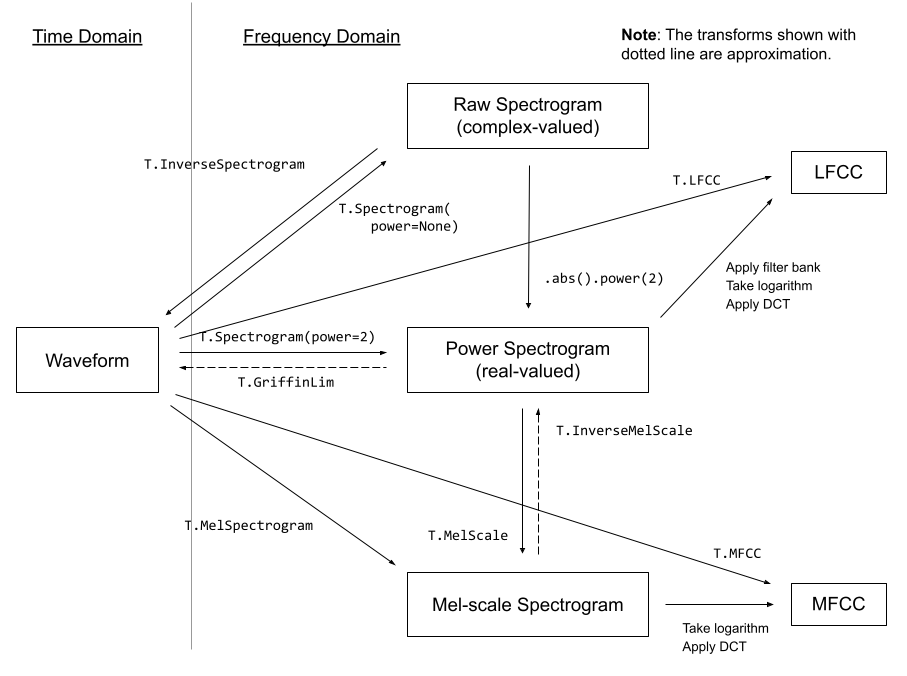

## **Load Audio Data**

In [4]:
# These settings are used for the Mel Spectrograms
sample_rate = 16000
x_res = 128 # x resolution of the spectrogram (time)
y_res = 128 # y resolution of the spectrogram (frequency - binned)
mel = Mel(x_res, y_res, sample_rate)

In [5]:
# Load the dataset of bird calls
birdcall_dataset = load_dataset("tglcourse/5s_birdcall_samples_top20")

README.md:   0%|          | 0.00/454 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/977 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9595 [00:00<?, ? examples/s]

In [6]:
birdcall_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 9595
    })
})

In [7]:
birdcall_dataset['train'][0]

{'audio': {'path': None,
  'array': array([ 0.00588989, -0.00027466, -0.006073  , ..., -0.00396729,
         -0.00161743,  0.00228882]),
  'sampling_rate': 32000},
 'label': 'rewbla'}

In [8]:
# Resampling the audio to match the target sample rate
sample_rate_dataset = 32000
resampler = T.Resample(sample_rate_dataset, sample_rate, dtype=torch.float32)

In [13]:
# Transformations to turn an audio array into a PIL image
import random
def to_image(audio_array):
  audio_tensor = torch.tensor(audio_array).to(torch.float32) #array to float
  audio_tensor = resampler(audio_tensor)
  mel.load_audio(raw_audio=np.array(audio_tensor))
  num_slices = mel.get_number_of_slices()
  slice_idx = random.randint(0, num_slices - 1) # Grab a random slice each time (excluding last short slice)
  im = mel.audio_slice_to_image(slice_idx)
  return im

In [14]:
# Class to return an image from the Dataset
class ImageDS:
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self): return len(self.dataset)

  def __getitem__(self, i):
    audio_array = self.dataset[i]['audio']['array']
    im = to_image(audio_array, )
    im = TF.to_tensor(im) - 0.5
    im = TF.resize(im, (x_res, y_res))
    return (im,)

In [15]:
# Training and Validation sets
tds = ImageDS(birdcall_dataset['train'].select(range(9000)))
vds = ImageDS(birdcall_dataset['train'].select(range(9000, 9500)))

In [16]:
tds[0][0].shape

torch.Size([1, 128, 128])